In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train=pd.read_csv('Train_Sample.csv',sep=';')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65974 entries, 0 to 65973
Columns: 223 entries, Id to Status
dtypes: bool(3), float64(109), int64(108), object(3)
memory usage: 110.9+ MB


In [5]:
## Column that only has missing values is par 71
train.columns[train.isnull().sum()>0]

Index(['par71'], dtype='object')

In [6]:
train.head(5)

,Id,par1,par2,par3,par4,par5,par6,par7,par8,par9,...,par215,par216,par217,par218,par219,par220,par221,par222,par223,Status
0,1,10,1.111111,10,0,1249,2686.375,1.625,16213,6.00,...,11.333333,9,0,0,0.000000,0,426,4647.333333,69,0
1,2,10,0.000000,0,0,2974,15810.750,1.500,15487,11.50,...,30.000000,1,0,0,0.000000,0,2547,12022.250000,29,0
2,3,40,0.647059,22,8,5801,8175.375,1.625,72254,2.75,...,7.636364,11,1050,16,688.833333,8266,425,12705.176470,181,0
3,4,16,2.076923,27,2,8761,8818.400,1.400,23754,4.50,...,24.125000,8,2000,14,1636.944444,117860,2135,12814.533330,71,0
4,5,10,0.454545,5,1,5958,9778.000,1.000,5958,4.00,...,28.000000,1,0,0,0.000000,0,857,10088.909090,45,0


0    0.928927
1    0.071073
Name: Status, dtype: float64


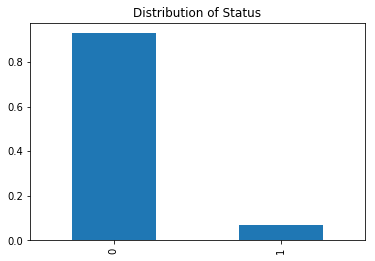

In [31]:
(train.Status.value_counts()/train.shape[0]).plot(kind='bar')
plt.title('Distribution of Status')
print(train.Status.value_counts()/train.shape[0])

plt.savefig("y_dist.png")

In [8]:
train.dtypes.value_counts()

float64    109
int64      108
object       3
bool         3
dtype: int64

In [9]:
train.loc[:,train.dtypes==object].head(10)

,par53,par61,par71
0,Chrome,mail.ua,moneyveo.ua
1,Opera,bigmir.net,google.com.ua
2,Chrome,gmail.com,googleadservices.com
3,Chrome,i.ua,googleadservices.com
4,Safari,mail.ru,NaN
5,Chrome,gmail.com,NaN
6,Chrome,mail.ru,NaN
7,Chrome,yandex.ua,yandex.ua
8,Chrome,mail.ru,rdr.salesdoubler.com.ua
9,Chrome,bk.ru,go.mail.ru


In [10]:
train.loc[:,train.dtypes==bool].head(10)

,par60,par68,par200
0,True,False,True
1,True,False,True
2,True,True,True
3,True,False,True
4,True,False,True
5,False,True,True
6,True,True,True
7,False,True,True
8,True,True,True
9,False,True,False


In [11]:
## train[['par60', 'par68','par200']] = train[['par60', 'par68','par200']].astype(int)

In [12]:
train.columns[train.dtypes==bool]

Index(['par60', 'par68', 'par200'], dtype='object')

## Let's build a benchmark model as fast as possible

In [13]:
## dropping object columns and only using numeric data by using logistic regression

In [14]:
train_num=train.drop(columns=train.columns[train.dtypes==object]).drop(columns='Id')

In [15]:
train.columns[train.dtypes==object]

Index(['par53', 'par61', 'par71'], dtype='object')

In [16]:
y=train.Status
train_num.drop(columns='Status',inplace=True)

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=22)

for train_index, val_index in sss.split(train_num, y):
    print("TRAIN:", train_index, "VAL:", val_index)
    X_train, X_val = train_num.iloc[train_index,:], train_num.iloc[val_index,:]
    y_train, y_val = y[train_index], y[val_index]

TRAIN: [ 4935 25551 61271 ...  9337 12070 29357] VAL: [14537 59552 25318 ... 38813   750 20012]


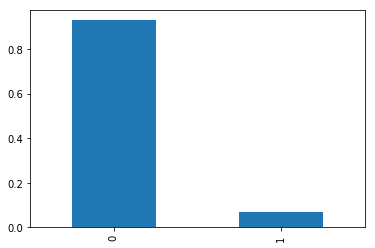

In [18]:
(y_train.value_counts()/y_train.shape[0]).plot(kind='bar')
y_train.value_counts()/y_train.shape[0]
plt.savefig("y_dist.png")

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [20]:
clf = LogisticRegression(random_state=22, solver='lbfgs',class_weight='balanced',n_jobs=-1).fit(X_train, y_train)

In [21]:
roc_auc_score(y_val, clf.predict_proba(X_val)[:,1] )

0.7620410077548043

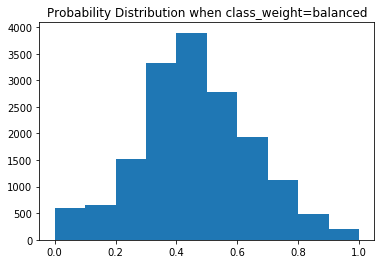

In [37]:
plt.hist( clf.predict_proba(X_val)[:,1] )
plt.title('Probability Distribution when class_weight=balanced')
plt.savefig('balanced.png')

0.18621604212876333


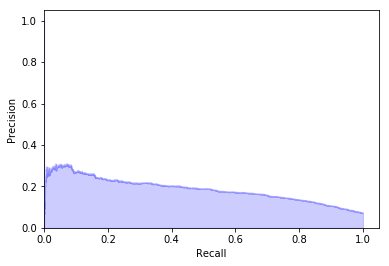

In [33]:
from sklearn.metrics import precision_recall_curve 
from inspect import signature
from sklearn.metrics import average_precision_score

y_pred=clf.predict_proba(X_val)[:,1]
ave_prec=average_precision_score(y_val,y_pred)  
print(ave_prec)
precision, recall, _ = precision_recall_curve(y_val, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.show()


### So, the benchmark score with logistic regression for this dataset is .762

In [24]:
clf2 = LogisticRegression(random_state=22, solver='lbfgs',n_jobs=-1).fit(X_train, y_train)

In [25]:
roc_auc_score(y_val, clf2.predict_proba(X_val)[:,1] )

0.5980782056005486

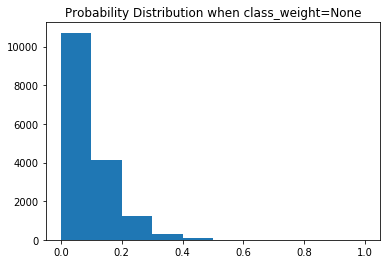

In [38]:
plt.hist( clf2.predict_proba(X_val)[:,1] )
plt.title('Probability Distribution when class_weight=None')
plt.savefig('None.png')

0.11008662011996195


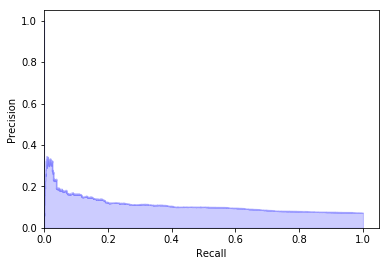

In [27]:
y_pred2=clf2.predict_proba(X_val)[:,1]
ave_prec=average_precision_score(y_val,y_pred2)  
print(ave_prec)
precision, recall, _ = precision_recall_curve(y_val, y_pred2)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.show()
